In [1]:
import torch
from torch import nn
from tqdm.notebook import tqdm
from dataloaders import create_dataloaders

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding="same")
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding="same")
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same")
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3,
                               stride=1, padding="same")
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3,
                               stride=1, padding="same")
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*7*7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)
        self.ReLu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.bn1(self.ReLu(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(self.bn2(self.ReLu(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(self.bn3(self.ReLu(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(self.bn4(self.ReLu(self.conv4(x))))
        x = self.dropout(x)
        x = self.pool(self.bn5(self.ReLu(self.conv5(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.ReLu(self.fc1(x))
        x = self.dropout(x)
        x = self.ReLu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [3]:
resnet_mean = torch.tensor([0.485, 0.456, 0.406])
resnet_std = torch.tensor([0.229, 0.224, 0.225])
train_loader, val_loader, test_loader = create_dataloaders(
    mean=resnet_mean,
    std=resnet_std,
    normalize=False,
    limit=None)

--Data Balance-- balance_data set to True. Training data will be balanced.
--Data Balance-- The most common class is 0 with 5364 images.
--Data Balance-- The second common class is 4 with 890 images with a difference of 4474 images from the most common class.
--Data Balance (Undersampling)-- Removing 2682 from 0 class..
--Data Balance (Undersampling)-- 0 now has 2682 images
-- Data Balance (Oversampling) -- Adding 2420 from 1 class..
-- Data Balance (Oversampling) -- Adding 1803 from 2 class..
-- Data Balance (Oversampling) -- Adding 2271 from 3 class..
-- Data Balance (Oversampling) -- Adding 1792 from 4 class..
-- Data Balance (Oversampling) -- Adding 2568 from 5 class..
-- Data Balance (Oversampling) -- Adding 2590 from 6 class..


Loading images: 18774it [03:03, 102.56it/s]


---Data Loader--- Images uploaded: 18774
Loading complete, some files (0) were not found: []


Loading images: 2003it [00:21, 94.26it/s] 


---Data Loader--- Images uploaded: 2003
Loading complete, some files (0) were not found: []


Loading images: 1512it [00:11, 131.61it/s]


---Data Loader--- Images uploaded: 1511
Loading complete, some files (1) were not found: ['data/HAM10000_images_test/ISIC_0035068.jpg']


In [12]:
from utils import crop_roi


torch.set_printoptions(precision=2)

device = torch.device("mps")
model = CNN().to(device)

hparams = {
    'lr': 0.001,
    'epochs': 50,
    # 'weight_decay': None
}

optimizer = torch.optim.Adam(
    model.parameters(), lr=hparams['lr'])
criterion = nn.CrossEntropyLoss()

losses = []

best_val_loss = float('inf')

batch: torch.Tensor
labels: torch.Tensor
segmentations: torch.Tensor
for epoch in tqdm(range(hparams['epochs']), desc="Epochs"):
    model.train()
    pbar = tqdm(train_loader, desc="Training")
    training_count = 0
    training_correct_preds = 0
    for (batch, labels, segmentations) in train_loader:
        masked_image = batch * segmentations
        masked_image = crop_roi(masked_image)
        masked_image = masked_image.to(device)

        preds = model(masked_image)
        labels = labels.to(device)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            training_preds = torch.argmax(preds, -1).detach()
            training_count += len(labels)
            training_correct_preds += (training_preds == labels).sum()

        losses.append(loss.item())

        pbar.set_description(f"Training loss: {loss.item():.4f}, Accuracy: {(training_correct_preds / training_count):.4f}")
        pbar.update()
    print(f"Epoch {epoch} training loss: {loss.item()}")
    print(f"Epoch {epoch} training accuracy: {training_correct_preds / training_count}")
    pbar.close()

    # pbar = tqdm(val_loader, desc="Validation")
    model.eval()
    with torch.no_grad():
        val_count = 0
        val_correct_preds = 0
        for (batch, labels, segmentations) in val_loader:
            masked_image = batch * segmentations
            masked_image = crop_roi(masked_image)
            batch = masked_image.to(device)

            assert labels.shape == (batch.shape[0],)
            
            preds = model(batch)
            labels = labels.to(device)
            loss = criterion(preds, labels)

            val_preds = torch.argmax(preds, -1).detach()
            val_count += len(labels)
            val_correct_preds += (val_preds == labels).sum()



            # pbar.set_description(f"Validation loss: {loss.item():.4f}")
            # pbar.update()
        print(f"Epoch {epoch} validation accuracy: {val_correct_preds / val_count}")
        print(f"Epoch {epoch} validation loss: {loss.item()}")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 0 training loss: 1.2864296436309814
Epoch 0 training accuracy: 0.3734952509403229
Epoch 0 validation accuracy: 0.6220669150352478
Epoch 0 validation loss: 2.6691596508026123


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1 training loss: 1.3045295476913452
Epoch 1 training accuracy: 0.4689464271068573
Epoch 1 validation accuracy: 0.43185222148895264
Epoch 1 validation loss: 1.9027818441390991


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2 training loss: 1.5490524768829346
Epoch 2 training accuracy: 0.507989764213562
Epoch 2 validation accuracy: 0.528706967830658
Epoch 2 validation loss: 1.9644695520401


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3 training loss: 1.203896164894104
Epoch 3 training accuracy: 0.5324384570121765
Epoch 3 validation accuracy: 0.5381926894187927
Epoch 3 validation loss: 1.924798846244812


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 4 training loss: 0.9937198162078857
Epoch 4 training accuracy: 0.5592840909957886
Epoch 4 validation accuracy: 0.5536695122718811
Epoch 4 validation loss: 1.8546805381774902


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 5 training loss: 0.541754961013794
Epoch 5 training accuracy: 0.5850111842155457
Epoch 5 validation accuracy: 0.5551672577857971
Epoch 5 validation loss: 1.7152067422866821


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 6 training loss: 0.878394365310669
Epoch 6 training accuracy: 0.6039735674858093
Epoch 6 validation accuracy: 0.5381926894187927
Epoch 6 validation loss: 1.5782047510147095


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 7 training loss: 0.8383362293243408
Epoch 7 training accuracy: 0.6162245869636536
Epoch 7 validation accuracy: 0.5396904349327087
Epoch 7 validation loss: 1.5724403858184814


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 8 training loss: 0.9510907530784607
Epoch 8 training accuracy: 0.6327900290489197
Epoch 8 validation accuracy: 0.6220669150352478
Epoch 8 validation loss: 2.1415750980377197


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 9 training loss: 1.65582275390625
Epoch 9 training accuracy: 0.6406732797622681
Epoch 9 validation accuracy: 0.6225661635398865
Epoch 9 validation loss: 1.5840970277786255


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 10 training loss: 0.628886342048645
Epoch 10 training accuracy: 0.6487163305282593
Epoch 10 validation accuracy: 0.6380429267883301
Epoch 10 validation loss: 2.0009284019470215


Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 11 training loss: 0.7979511022567749
Epoch 11 training accuracy: 0.6626718044281006
Epoch 11 validation accuracy: 0.6340489387512207
Epoch 11 validation loss: 2.3393566608428955


Training:   0%|          | 0/294 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
torch.save(model, "./model_acc_0.73_epoch_12.pth")

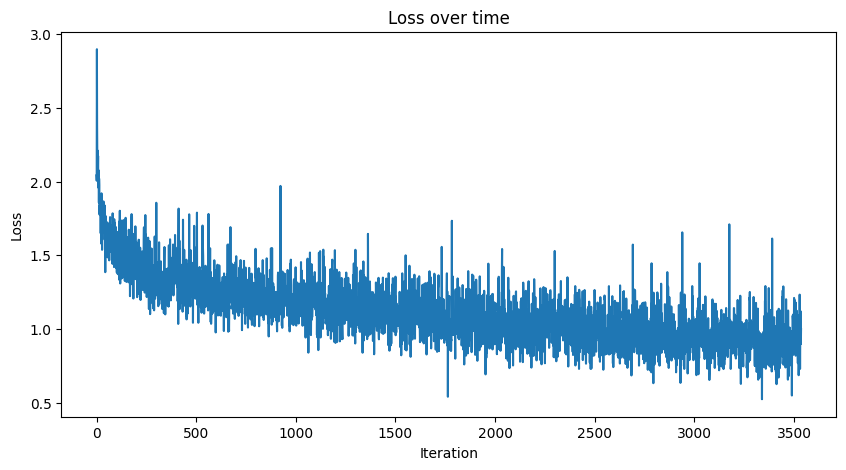

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()